# BT4222 Final Project

## COVID-19 Fake News Classifier

Group 13

## Importing Packages

In [1]:
# EDA
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import save,load
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster.elbow import kelbow_visualizer
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# NLP 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, log_loss, precision_score, recall_score, roc_auc_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans

import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

from gensim.models import Word2Vec
import gensim

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import utils, layers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Ensemble
import xgboost
from sklearn.ensemble import RandomForestClassifier

# Probabilistic 
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

# Online
from sklearn.linear_model import PassiveAggressiveClassifier


# Support
import re
import os
from collections import Counter
import logging
import time
import pickle
import itertools
import gc

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\edmun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\edmun\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Settings

In [2]:
# SETTINGS
GOOGLE_COLAB = False # If using Google Colab, set to true, else false.
RANDOM_STATE = 42

# DATASET
TRAIN_SIZE = 0.8

#SETTINGS
RANDOM_STATE = 42

#DATASET
TRAIN_SIZE = 0.8

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# TENSORFLOW
SEQUENCE_LENGTH = 300
EPOCHS = 32
BATCH_SIZE = 1024

gc.collect()

0

## Loading Datasets

In [3]:
train_ds = pd.read_csv("https://raw.githubusercontent.com/edologgerbird/BT4222_project/main/data/Constraint_Train.csv")
val_ds = pd.read_csv("https://raw.githubusercontent.com/edologgerbird/BT4222_project/main/data/Constraint_Val.csv")
df = pd.concat([train_ds,val_ds]).reset_index()

In [4]:
df.head()

,index,id,tweet,label
0,0,1,The CDC currently reports 99031 deaths. In gen...,real
1,1,2,States reported 1121 deaths a small rise from ...,real
2,2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,4,5,Populous states can generate large case counts...,real


In [5]:
df.label.unique()

array(['real', 'fake'], dtype=object)

In [6]:
df = df.drop('id', axis=1)

## Sanity Check




In this section, we check for:
1.   Null inputs
2.   Duplicated rows

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8560 entries, 0 to 8559
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   8560 non-null   int64 
 1   tweet   8560 non-null   object
 2   label   8560 non-null   object
dtypes: int64(1), object(2)
memory usage: 200.8+ KB


In [8]:
df.duplicated().sum()

0

In [9]:
df.label.value_counts()

real    4480
fake    4080
Name: label, dtype: int64

<AxesSubplot:>

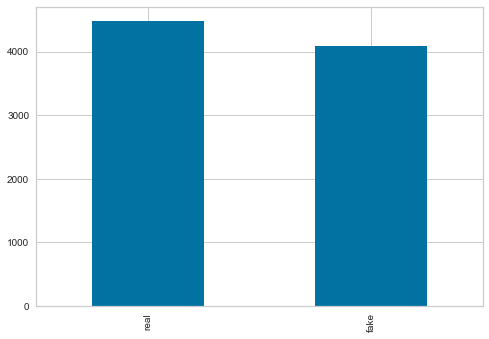

In [10]:
df.label.value_counts().plot(kind='bar')

## Data Pre-processing

In [11]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
lemmer = WordNetLemmatizer()

In [12]:
", ".join(stop_words)


"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

### Previewing Tweets

In [13]:
print(df.tweet.sample(15).values)

['#IndiaFightsCorona: 1098621 tests were conducted in the last 24 hours testifying the enlarged testing capacity in the country. Details : https://t.co/CZlYzlShnr #StaySafe #IndiaWillWin https://t.co/31mYyocg0o'
 "Based on previous situations where California reported like this the reporting jump likely had to do with matching *tests completed* to individual patients in the state. We're not sure why they are batch processing like this but it's the second time it has happened."
 'Greece is the number one country in terms of how many coronavirus tests have been conducted for each confirmed case.'
 'Our daily update is published. Mondays are now the day where the weekend lag shows up most acutely. States reported 735K tests 58K cases and 365 deaths (last Monday: 327). https://t.co/kprzMhy5Pp'
 'Sadly today there are three people in hospital with COVID-19 – one is in isolation on a ward in Auckland City Hospital. Two are in ICU at North Shore and Waikato hospitals. We want to send them and

### Creating a column for word count

In [14]:
df['length'] = df['tweet'].apply(lambda x: len(x.split()))

### Preliminary Length Analysis

In [15]:
df['length'].describe()

count    8560.00000
mean       26.94778
std        22.45087
min         3.00000
25%        15.00000
50%        25.00000
75%        37.00000
max      1456.00000
Name: length, dtype: float64

<AxesSubplot:>

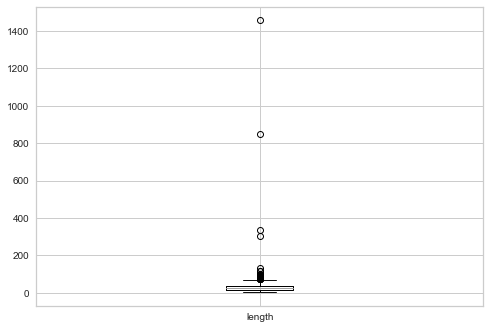

In [16]:
df.boxplot(column=['length'])

We notice outliers with extreme number of words. Previewing outlier articles here.

In [17]:
df[df['length']>150]

,index,tweet,label,length
270,270,"Amoxi"" Capsule made in US is the only medicine...",fake,1456
1109,1109,"Actors"" applauded Macron when he visited the s...",fake,847
6306,6306,Man visited Albany N.Y. days before dying from...,fake,336
8153,1733,I'm so happy that we’re able to do something v...,real,304


In [18]:
for tweet in df['tweet'][df['length']>150].values:
  print(tweet)

Amoxi" Capsule made in US is the only medicine that can completely cure COVID-19.
Egyptian Health Minister arrive in Italy with secret coronavirus cure.
 Dr Charles Lieber a Harvard professor has been arrested in the USA for manufacturing the coronavirus and selling it to China. A video news report from WCVB a TV station in Boston Massachusetts is shared with the Facebook post.
Mountain Matterhorn in Switzerland was lit in three colours of Indian flag as a token of gratitude to India for sending Hydroxychloroquine.
Al-Azhar Imam said he is considering exceptions on Ramadan fasting as the research says that the mouth must be kept wet to prevent COVID-19
 Japanese Nobel Tasuku Honjo says coronavirus was created in the Wuhan laboratory
A man collapses in 5 minutes after showing COVID-19 symptoms in India.
Celebrities spreading misinformation about coronavirus and the Janata curfew in India.
 Multiple posts shared repeatedly on Facebook and Twitter since March 2020 claim that Israel has re

We will remove the outlier articles to reduce noise when building our models.

In [19]:
df = df[df['length'] < 150]

(0.0, 200.0)

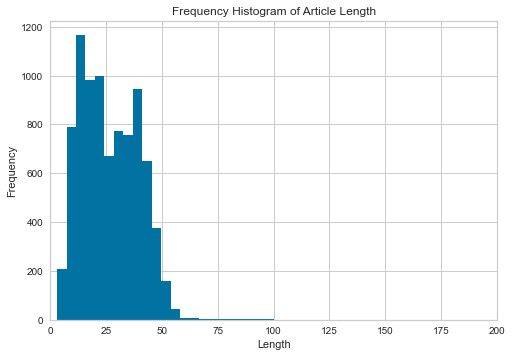

In [20]:
plt.hist(df['length'],bins=30)
plt.gca().set(title='Frequency Histogram of Article Length', ylabel='Frequency', xlabel='Length')
plt.xlim(0,200)


### Text Cleaning

- Transform to lowercase
- Remove trailing white spaces
- Remove stopwords
- Stem and lemmatize words to root form

In [21]:
TEXT_CLEANING_RE = "https?:\S+|http?:\S|[^A-Za-z0-9]+"

def preprocess(text):
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            tokens.append(lemmer.lemmatize(stemmer.stem(token)))
    return " ".join(tokens)

In [22]:
df.tweet = df.tweet.apply(lambda x:preprocess(x))

In [23]:
print(df.tweet.sample(15).values)

['indiafightscorona new death near 53 concentr three state maharashtra karnataka uttar pradesh follow tamil nadu punjab andhra pradesh'
 'kmedv one wrinkl data one way think know miss lot data posit rate start go also worth note see upper bound posit rate'
 'high alert dear brother sister relat chicken infect corona virus found bangalor today kind circul messag avoid consumpt chicken spread dear one'
 'daili updat publish track 18 7 million test 465k yesterday second highest daili total seen note track test state report detail see'
 'know feel like virus pas last forev first minist nicola sturgeon thank peopl scotland sacrific made far get latest new restrict'
 'region u defin census size south twice mani peopl northeast outbreak intens spring 200 million peopl live region case grow quick'
 'scale test key ass covid19nigeria situat coordin respons across countri kind note covid19 test conduct facil within ncdc molecular lab network free charg view full list via'
 'latest cdc covidview 

## Exploratory Data Analysis

### Length Analysis

<AxesSubplot:title={'center':'length'}, xlabel='label'>

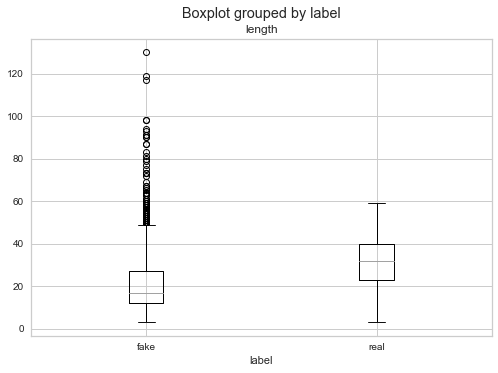

In [24]:
df.boxplot(column=["length"], by="label")

<AxesSubplot:xlabel='length', ylabel='Density'>

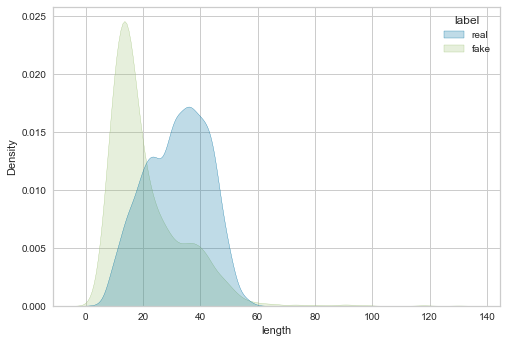

In [25]:
sns.kdeplot(data=df, x="length", hue="label", shade=True)

Fake news tends to be short than real news. 

### Word Clouds

#### Setting word exclusions from our wordclouds

In [26]:
cloud_stop = set(STOPWORDS)
cloud_stop.update(["covid", "coronavirus", "case", "covid-19", "peopl", "covid19", "amp"])

In [27]:
def generate_wordcloud(text):
    wordcloud = WordCloud(stopwords=cloud_stop, background_color="white").generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

#### Word Cloud for ALL text

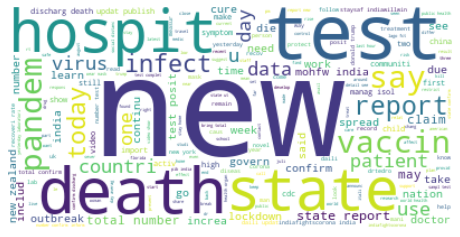

In [28]:
all_text = " ".join(tweet for tweet in df.tweet)
generate_wordcloud(all_text)

#### Word Cloud for Fake News

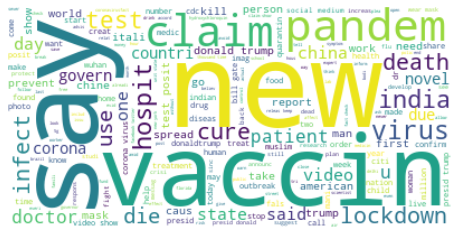

In [28]:
fake_text = " ".join(tweet for tweet in df[df['label']== 'fake'].tweet)
generate_wordcloud(fake_text)

#### Word Cloud for Real News

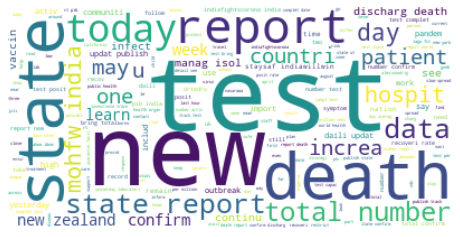

In [29]:
real_text = " ".join(tweet for tweet in df[df['label']== 'real'].tweet)
generate_wordcloud(real_text)

## Preparing Training and Testing Data

In [30]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=RANDOM_STATE)
print("TRAIN size: ", len(df_train))
print("TEST size: ", len(df_test))

TRAIN size:  6844
TEST size:  1712


### Label Encoding

In [31]:
encoder = LabelEncoder()
encoder.fit(df_train.label.tolist())

y_train  = encoder.transform(df_train.label.tolist())
y_test  = encoder.transform(df_test.label.tolist())

y_train  = y_train .reshape(-1,1)
y_test  = y_test.reshape(-1,1)

In [32]:
print("y_train", y_train.shape)
print("y_test", y_test.shape)

y_train (6844, 1)
y_test (1712, 1)


## Text Vectorisation Methods

### Count Vectorisation

In [33]:
count_vectorizer = CountVectorizer()
x_train_countv = count_vectorizer.fit_transform(df_train.tweet).astype(np.float64)
x_test_countv = count_vectorizer.transform(df_test.tweet).astype(np.float64)

#### Previewing Vocabulary

In [34]:
pd.DataFrame(count_vectorizer.vocabulary_, index=[0]).T

,0
nasser,7401
ziberi,11036
test,10015
posit,8212
covid,3796
...,...
danielleiwood,3974
bleak,2863
bankofamerica,2638
mandetta,6870


### TF-IDF Vectorisation

#### Vectorising Text Using TF-IDF Vectorizer

In [35]:
tfidf_vectorizer = TfidfVectorizer()
x_train_tfidf = tfidf_vectorizer.fit_transform(df_train.tweet)
x_test_tfidf = tfidf_vectorizer.transform(df_test.tweet)

#### Previewing Sparse TF-IDF Vector

In [36]:
train_tfidf_sklearn = pd.DataFrame(x_train_tfidf.toarray(),columns=tfidf_vectorizer.get_feature_names_out())
train_tfidf_sklearn.sort_index().round(decimals=5)
train_tfidf_sklearn 

,00,000,006,00ice,00pm,01,011,0141,02,03,...,zoo,zoodirector,zookeep,zoolog,zoom,zoonot,zuckoff,zurich,zydus,zyphr
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6839,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6841,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6842,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Previewing Words with Highest TFIDF Score

In [37]:
train_tfidf_sklearn = train_tfidf_sklearn.stack().reset_index()
train_tfidf_sklearn = train_tfidf_sklearn.rename(columns={0:'tfidf', 'level_0': 'id','level_1': 'term', 'level_2': 'term'})
train_tfidf_sklearn_sorted = train_tfidf_sklearn.sort_values(by=['id','tfidf'], ascending=[True,False]).groupby(['id'])


In [38]:
train_tfidf_sklearn_sorted.head(10)

,id,term,tfidf
7401,0,nasser,0.644215
11036,0,ziberi,0.644215
8212,0,posit,0.284045
10015,0,test,0.196617
488,0,19,0.164663
...,...,...,...
75656208,6843,00,0.000000
75656209,6843,000,0.000000
75656210,6843,006,0.000000
75656211,6843,00ice,0.000000


In [39]:
gc.collect()

0

### Word2Vec Model

#### Building Documents

In [40]:
documents = [tweet.split() for tweet in df_train.tweet]

#### Initialising word2vec model with hyperparameters

In [41]:
if GOOGLE_COLAB:
    w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                                window=W2V_WINDOW, 
                                                min_count=W2V_MIN_COUNT, 
                                                workers=8)
else:
    w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                                window=W2V_WINDOW, 
                                                min_count=W2V_MIN_COUNT, 
                                                workers=8)


#### Building Vocab

In [42]:
w2v_model.build_vocab(documents)

#### Training word2vec model

In [43]:
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

(2663961, 3787264)

In [44]:
w2v_model.wv.most_similar("covid")


[('coronaupd', 0.3813735544681549),
 ('drhvoffic', 0.3435191810131073),
 ('coronavirusindia', 0.3394179046154022),
 ('nine', 0.33426448702812195),
 ('covidupd', 0.3327307403087616),
 ('acquir', 0.3154052197933197),
 ('treat', 0.2993341386318207),
 ('link', 0.29327118396759033),
 ('n', 0.2923400402069092),
 ('covid19india', 0.2915962338447571)]

#### Tokenise Text

In [45]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.tweet)

vocab_size = len(tokenizer.word_index) + 1
print("Total unique words", vocab_size)

Total unique words 11088


#### Previewing top 20 words by Count

In [46]:
token_count = dict(tokenizer.word_counts)
token_count_df = pd.DataFrame(dict(sorted(token_count.items(), key=lambda item: item[1], reverse=True)),index=["Count"]).T
token_count_df.head(20)

,Count
covid,2538
case,2176
19,2137
test,1810
coronavirus,1706
covid19,1584
new,1163
report,1099
state,1095
death,870


#### Converting text to sequence of integers

In [47]:
x_train_word2vec = tokenizer.texts_to_sequences(df_train.tweet)
x_test_word2vec = tokenizer.texts_to_sequences(df_test.tweet)

#### Padding

In [48]:
x_train_word2vec  = pad_sequences(x_train_word2vec , maxlen=SEQUENCE_LENGTH)
x_test_word2vec  = pad_sequences(x_test_word2vec , maxlen=SEQUENCE_LENGTH)

#### Embedding Matrix

Populating matrix with weights

In [49]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(11088, 300)


## Model Building

In [72]:
training_data = [x_train_countv, x_train_tfidf, x_train_word2vec]
testing_data = [x_test_countv, x_test_tfidf, x_test_word2vec]

METRICS = ['accuracy', 'Precision','Recall','AUC']

CALLBACKS = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

EPOCHS = 1

results_store = {}

### Helper Functions

In [80]:
def batch_generator(x, y, batch_size):
    samples_per_epoch = x.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    index = np.arange(np.shape(y)[0])
    while 1:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
        x_batch = x[index_batch,:].toarray()
        y_batch = y[min(index_batch):max(index_batch)+1]
        counter += 1
        x_batch = np.expand_dims(x_batch, axis=2)
        yield x_batch, np.array(y_batch)
        if (counter > number_of_batches):
            counter=0

def get_F1(precision, recall):
    if precision == recall == 0:
        return 0
    return 2* (precision*recall)/(precision+recall)

def get_results(history):
    loss = history[0]
    accuracy = history[1]
    precision = history[2]
    recall = history[3]
    auc = history[4]
    F1 = get_F1(precision,recall)
    results ={
        "Loss": loss,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "AUC": auc,
        "F1 Score": F1
    }
    return results

def get_evaluation_vect(model, x_test, model_name, vectoriser):
    name = model_name + " " + vectoriser
    x_test_DL = np.expand_dims(x_test.toarray(), axis=2)
    eval = model.evaluate(x_test_DL, y_test, batch_size=32)
    result = get_results(eval)
    result["model"] = model_name
    result["vectoriser"] = vectoriser
    results_store[name] = result
    return result

def get_deep_learning_results_vect(model, model_name):
    gc.collect()
    model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=METRICS)
    
    #count_vectorizer
    print("\n >>> Training Count Vectorisation Model ========================================= \n")
    fit_countv = model.fit(
        batch_generator(x_train_countv, y_train, 32),
        epochs = EPOCHS,
        steps_per_epoch=x_train_countv.shape[0]/32
    )
    result_countv = get_evaluation_vect(model, x_test_countv, model_name, "count")

    #tf-idf vectorizer
    print("\n >>> Training TFIDF Vectorisation Model ========================================= \n")
    fit_tfidf = model.fit(
        batch_generator(x_train_tfidf, y_train, 32),
        epochs = EPOCHS,
        steps_per_epoch=x_train_tfidf.shape[0]/32      
    )
    result_tfidf = get_evaluation_vect(model, x_test_tfidf, model_name, "tfidf")

    
    return pd.DataFrame(results_store).T

def get_evaluation_w2v(model, model_name, vectoriser):
    name = model_name + " " + vectoriser
    eval = model.evaluate(x_test_word2vec , y_test , batch_size=BATCH_SIZE)
    result = get_results(eval)
    result["model"] = model_name
    result["vectoriser"] = vectoriser
    results_store[name] = result
    return result

def get_deep_learning_results_w2v(model, model_name):
    gc.collect()
    model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=METRICS)
              
    print("\n >>> Training Word2Vec Model ========================================= \n")
    fit_word2vec = model.fit(
        x_train_word2vec , y_train ,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_split=0.1,
        verbose=1,
        callbacks=CALLBACKS
    )
    result_word2vec = get_evaluation_w2v(model, model_name, "word2vec")
    
    return pd.DataFrame(results_store).T

## Deep Learning Models

### TextCNN

In [78]:
cnn_vect_model = tf.keras.Sequential([
    layers.Conv1D(128, 5, activation='relu', input_shape=(None,1)),
    layers.GlobalMaxPooling1D(),
    layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

get_deep_learning_results_vect(cnn_vect_model, "CNN")



 >>> Training Count Vectorisation Model ========================================= 

54/54 [==============================] - 2s 34ms/step - loss: 0.6206 - accuracy: 0.7091 - precision: 0.7183 - recall: 0.7068 - auc: 0.7385

 >>> Training TFIDF Vectorisation Model ========================================= 

54/54 [==============================] - 2s 34ms/step - loss: 0.6935 - accuracy: 0.4901 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000


,Loss,Accuracy,Precision,Recall,AUC,F1 Score,model,vectoriser
CNN count,0.62063,0.709112,0.718277,0.706758,0.738538,0.712471,CNN,count
CNN tfidf,0.693543,0.49007,0.0,0.0,0.5,0,CNN,tfidf
xgb count,0.501631,0.833528,0.900545,0.757159,0.912966,0.822651,xgb,count
xgb tfidf,0.502491,0.837617,0.902571,0.764032,0.911714,0.827543,xgb,tfidf
xgb word2vec,0.556457,0.771612,0.769575,0.788087,0.846835,0.778721,xgb,word2vec


In [81]:
cnn_word2vec_model = tf.keras.Sequential([
    layers.Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False),
    layers. Conv1D(128, 5, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

get_deep_learning_results_w2v(cnn_word2vec_model, "CNN")


 >>> Training Word2Vec Model ========================================= 

2/2 [==============================] - 0s 114ms/step - loss: 0.2720 - accuracy: 0.8849 - precision: 0.8894 - recall: 0.8843 - auc: 0.9572


,Loss,Accuracy,Precision,Recall,AUC,F1 Score,model,vectoriser
CNN count,0.62063,0.709112,0.718277,0.706758,0.738538,0.712471,CNN,count
CNN tfidf,0.693543,0.49007,0.0,0.0,0.5,0,CNN,tfidf
xgb count,0.501631,0.833528,0.900545,0.757159,0.912966,0.822651,xgb,count
xgb tfidf,0.502491,0.837617,0.902571,0.764032,0.911714,0.827543,xgb,tfidf
xgb word2vec,0.556457,0.771612,0.769575,0.788087,0.846835,0.778721,xgb,word2vec
CNN word2vec,0.27199,0.88493,0.889401,0.884307,0.957213,0.886847,CNN,word2vec


### LSTM (Unidirectional)

In [54]:
lstm_vect_model = tf.keras.Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=(None,1)),
    layers.GlobalMaxPooling1D(),
    layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

get_deep_learning_results_vect(lstm_vect_model, "LSTM")



 >>> Training Count Vectorisation Model ========================================= 

54/54 [==============================] - 12s 191ms/step - loss: 0.6007 - accuracy: 0.7044 - precision: 0.7083 - recall: 0.7148 - auc: 0.7499

 >>> Training TFIDF Vectorisation Model ========================================= 

54/54 [==============================] - 12s 221ms/step - loss: 0.6926 - accuracy: 0.5099 - precision: 0.5099 - recall: 1.0000 - auc: 0.5000


,Loss,Accuracy,Precision,Recall,AUC,F1 Score
CNN count,0.620903,0.706776,0.723764,0.687285,0.731451,0.705053
CNN tfidf,0.685584,0.532710,0.522001,0.991982,0.661685,0.684044
CNN word2vec,0.301276,0.866822,0.843450,0.907216,0.948229,0.874172
LSTM count,0.600744,0.704439,0.708286,0.714777,0.749932,0.711517
LSTM tfidf,0.692592,0.509930,0.509930,1.000000,0.500000,0.675435


In [55]:
lstm_word2vec_model = tf.keras.Sequential([
    layers.Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False),
    layers.LSTM(64, return_sequences=True),
    layers.GlobalMaxPooling1D(),
    layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

get_deep_learning_results_w2v(lstm_word2vec_model, "LSTM")


 >>> Training Word2Vec Model ========================================= 

2/2 [==============================] - 0s 133ms/step - loss: 0.5430 - accuracy: 0.7675 - precision: 0.6939 - recall: 0.9737 - auc: 0.9276


,Loss,Accuracy,Precision,Recall,AUC,F1 Score
CNN count,0.620903,0.706776,0.723764,0.687285,0.731451,0.705053
CNN tfidf,0.685584,0.532710,0.522001,0.991982,0.661685,0.684044
CNN word2vec,0.301276,0.866822,0.843450,0.907216,0.948229,0.874172
LSTM count,0.600744,0.704439,0.708286,0.714777,0.749932,0.711517
LSTM tfidf,0.692592,0.509930,0.509930,1.000000,0.500000,0.675435
LSTM word2vec,0.543009,0.767523,0.693878,0.973654,0.927606,0.810296


### LSTM (Bidirectional)

In [56]:
bilstm_vect_model = tf.keras.Sequential([
    layers.Bidirectional(layers.LSTM(100, return_sequences=True, input_shape=(None,1))),
    layers.GlobalMaxPooling1D(),
    layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

#get_deep_learning_results_vect(bilstm_vect_model, "BiLSTM")


In [57]:
bilstm_word2vec_model = tf.keras.Sequential([
    layers.Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.5)),
    layers.GlobalMaxPooling1D(),
    layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

#get_deep_learning_results_w2v(bilstm_word2vec_model, "BiLSTM")

### LSTM + CNN

In [59]:
lstmcnn_vect_model = tf.keras.Sequential([
    layers.LSTM(100, return_sequences=True, input_shape=(None,1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(128, 5, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

get_deep_learning_results_vect(lstmcnn_vect_model, "LSTM+CNN")


 >>> Training Count Vectorisation Model ========================================= 

54/54 [==============================] - 13s 226ms/step - loss: 0.5982 - accuracy: 0.6933 - precision: 0.7644 - recall: 0.5762 - auc: 0.7512

 >>> Training TFIDF Vectorisation Model ========================================= 

54/54 [==============================] - 12s 217ms/step - loss: 0.6930 - accuracy: 0.5099 - precision: 0.5099 - recall: 1.0000 - auc: 0.5000


,Loss,Accuracy,Precision,Recall,AUC,F1 Score
CNN count,0.620903,0.706776,0.723764,0.687285,0.731451,0.705053
CNN tfidf,0.685584,0.532710,0.522001,0.991982,0.661685,0.684044
CNN word2vec,0.301276,0.866822,0.843450,0.907216,0.948229,0.874172
LSTM count,0.600744,0.704439,0.708286,0.714777,0.749932,0.711517
LSTM tfidf,0.692592,0.509930,0.509930,1.000000,0.500000,0.675435
LSTM word2vec,0.543009,0.767523,0.693878,0.973654,0.927606,0.810296
LSTM+CNN count,0.598234,0.693341,0.764438,0.576174,0.751175,0.657087
LSTM+CNN tfidf,0.692953,0.509930,0.509930,1.000000,0.500000,0.675435


In [60]:
lstmcnn_word2vec_model = tf.keras.Sequential([
    layers.Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False),
    layers.LSTM(100, return_sequences=True),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(128, 5, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
            
get_deep_learning_results_w2v(lstmcnn_word2vec_model, "LSTM+CNN")


 >>> Training Word2Vec Model ========================================= 

2/2 [==============================] - 1s 208ms/step - loss: 0.3285 - accuracy: 0.8779 - precision: 0.8593 - recall: 0.9095 - auc: 0.9479


,Loss,Accuracy,Precision,Recall,AUC,F1 Score
CNN count,0.620903,0.706776,0.723764,0.687285,0.731451,0.705053
CNN tfidf,0.685584,0.532710,0.522001,0.991982,0.661685,0.684044
CNN word2vec,0.301276,0.866822,0.843450,0.907216,0.948229,0.874172
LSTM count,0.600744,0.704439,0.708286,0.714777,0.749932,0.711517
LSTM tfidf,0.692592,0.509930,0.509930,1.000000,0.500000,0.675435
LSTM word2vec,0.543009,0.767523,0.693878,0.973654,0.927606,0.810296
LSTM+CNN count,0.598234,0.693341,0.764438,0.576174,0.751175,0.657087
LSTM+CNN tfidf,0.692953,0.509930,0.509930,1.000000,0.500000,0.675435
LSTM+CNN word2vec,0.328516,0.877921,0.859307,0.909507,0.947933,0.883695


## Ensemble Models

### Helper Methods

In [61]:
y_train

array([[0],
       [0],
       [0],
       ...,
       [1],
       [0],
       [0]])

In [76]:
training_data = [x_train_countv, x_train_tfidf, x_train_word2vec]
testing_data = [x_test_countv, x_test_tfidf, x_test_word2vec]

training_data_array = [x_train_countv.toarray(), x_train_tfidf.toarray(), x_train_word2vec]
testing_data_array = [x_test_countv.toarray(), x_test_tfidf.toarray(), x_test_word2vec]

names = ["count", "tfidf", "word2vec"]

def get_model_results(model, model_name, toarray):
    
    gc.collect()
    if toarray:
        training_data_list = training_data_array
        testing_data_list = testing_data_array
    else:
        training_data_list = training_data
        testing_data_list = testing_data
    for i in range(len(training_data)):
        x_train_iter = training_data_list[i]
        x_test_iter = testing_data_list[i]
        name = model_name + " " + str(names[i])
        model.fit(x_train_iter, y_train.ravel())
        pred_prob = model.predict_proba(x_test_iter)
        pred = model.predict(x_test_iter)
        loss = log_loss(y_test, pred_prob[:,1])
        accuracy = accuracy_score(y_test, pred)
        #accuracy = model.score(x_test_iter, y_test)
        precision = precision_score(y_test, pred)
        recall = recall_score(y_test, pred)
        auc = roc_auc_score(y_test, pred_prob[:,1])
        F1 = get_F1(precision,recall)
        results = {
            "Loss": loss,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "AUC": auc,
            "F1 Score": F1
        }
        results["model"] = model_name
        results["vectoriser"] = names[i]
        results_store[name] = results
    return pd.DataFrame(results_store).T

def pac_get_model_results(model, model_name, toarray):
    gc.collect()
    
    if toarray:
        training_data_list = training_data_array
        testing_data_list = testing_data_array
    else:
        training_data_list = training_data
        testing_data_list = testing_data
    for i in range(len(training_data)):
        x_train_iter = training_data_list[i]
        x_test_iter = testing_data_list[i]
        name = model_name + " " + str(names[i])
        model.fit(x_train_iter, y_train.ravel())
        #pred_prob = model.predict_proba(x_test_iter)
        pred = model.predict(x_test_iter)
        loss = log_loss(y_test, pred)
        accuracy = accuracy_score(y_test, pred)
        #accuracy = model.score(x_test_iter, y_test)
        precision = precision_score(y_test, pred)
        recall = recall_score(y_test, pred)
        auc = roc_auc_score(y_test, pred)
        F1 = get_F1(precision,recall)
        results = {
            "Loss": loss,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "AUC": auc,
            "F1 Score": F1
        }
        results["model"] = model_name
        results["vectoriser"] = names[i]
        results_store[name] = results
    return pd.DataFrame(results_store).T

### XGBoost

In [77]:
xgbmodel = xgboost.XGBClassifier(objective='binary:logistic',  n_estimators = 100, booster = 'gbtree', learning_rate = '0.007', eval_metric = 'auc',use_label_encoder=False)
get_model_results(xgbmodel, "xgb", toarray=False)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\Users\edmun\anaconda3\envs\gpuEnv\lib\site-packages\keras\backend.py", line 4483, in <genexpr>
    ta.write(time, out) for ta, out in zip(output_ta_t, flat_output))  File "C:\Users\edmun\anaconda3\envs\gpuEnv\lib\site-packages\tensorflow\python\util\tf_should_use.py", line 247, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),


,Loss,Accuracy,Precision,Recall,AUC,F1 Score,model,vectoriser
CNN count,0.60527,0.706776,0.723764,0.687285,0.73837,0.705053,CNN,count
CNN tfidf,0.685535,0.532126,0.521687,0.991982,0.65599,0.683774,CNN,tfidf
xgb count,0.501631,0.833528,0.900545,0.757159,0.912966,0.822651,xgb,count
xgb tfidf,0.502491,0.837617,0.902571,0.764032,0.911714,0.827543,xgb,tfidf
xgb word2vec,0.556457,0.771612,0.769575,0.788087,0.846835,0.778721,xgb,word2vec


### RandomForest

In [64]:
rfc = RandomForestClassifier(random_state=RANDOM_STATE)
get_model_results(rfc, "rfc", toarray=False)

,Loss,Accuracy,Precision,Recall,AUC,F1 Score
CNN count,0.620903,0.706776,0.723764,0.687285,0.731451,0.705053
CNN tfidf,0.685584,0.532710,0.522001,0.991982,0.661685,0.684044
CNN word2vec,0.301276,0.866822,0.843450,0.907216,0.948229,0.874172
LSTM count,0.600744,0.704439,0.708286,0.714777,0.749932,0.711517
LSTM tfidf,0.692592,0.509930,0.509930,1.000000,0.500000,0.675435
LSTM word2vec,0.543009,0.767523,0.693878,0.973654,0.927606,0.810296
LSTM+CNN count,0.598234,0.693341,0.764438,0.576174,0.751175,0.657087
LSTM+CNN tfidf,0.692953,0.509930,0.509930,1.000000,0.500000,0.675435
LSTM+CNN word2vec,0.328516,0.877921,0.859307,0.909507,0.947933,0.883695
xgb count,0.501631,0.833528,0.900545,0.757159,0.912966,0.822651


## Probabilistic Model

### Gaussian Naive Bayes Classifier

In [65]:
gnb = GaussianNB()
get_model_results(gnb, "gnb", toarray=True)

,Loss,Accuracy,Precision,Recall,AUC,F1 Score
CNN count,0.620903,0.706776,0.723764,0.687285,0.731451,0.705053
CNN tfidf,0.685584,0.532710,0.522001,0.991982,0.661685,0.684044
CNN word2vec,0.301276,0.866822,0.843450,0.907216,0.948229,0.874172
LSTM count,0.600744,0.704439,0.708286,0.714777,0.749932,0.711517
LSTM tfidf,0.692592,0.509930,0.509930,1.000000,0.500000,0.675435
LSTM word2vec,0.543009,0.767523,0.693878,0.973654,0.927606,0.810296
LSTM+CNN count,0.598234,0.693341,0.764438,0.576174,0.751175,0.657087
LSTM+CNN tfidf,0.692953,0.509930,0.509930,1.000000,0.500000,0.675435
LSTM+CNN word2vec,0.328516,0.877921,0.859307,0.909507,0.947933,0.883695
xgb count,0.501631,0.833528,0.900545,0.757159,0.912966,0.822651


### Multinomial Niave Bayes

In [66]:
mnb = MultinomialNB()
get_model_results(mnb, "mnb", toarray=True)

,Loss,Accuracy,Precision,Recall,AUC,F1 Score
CNN count,0.620903,0.706776,0.723764,0.687285,0.731451,0.705053
CNN tfidf,0.685584,0.532710,0.522001,0.991982,0.661685,0.684044
CNN word2vec,0.301276,0.866822,0.843450,0.907216,0.948229,0.874172
LSTM count,0.600744,0.704439,0.708286,0.714777,0.749932,0.711517
LSTM tfidf,0.692592,0.509930,0.509930,1.000000,0.500000,0.675435
LSTM word2vec,0.543009,0.767523,0.693878,0.973654,0.927606,0.810296
LSTM+CNN count,0.598234,0.693341,0.764438,0.576174,0.751175,0.657087
LSTM+CNN tfidf,0.692953,0.509930,0.509930,1.000000,0.500000,0.675435
LSTM+CNN word2vec,0.328516,0.877921,0.859307,0.909507,0.947933,0.883695
xgb count,0.501631,0.833528,0.900545,0.757159,0.912966,0.822651


## Online Learning Model

### Passive Aggressive Classier

In [67]:
pac = PassiveAggressiveClassifier(max_iter = 1000, C = 1, early_stopping = True)
pac_get_model_results(pac, "PAC", toarray=False)

,Loss,Accuracy,Precision,Recall,AUC,F1 Score
CNN count,0.620903,0.706776,0.723764,0.687285,0.731451,0.705053
CNN tfidf,0.685584,0.532710,0.522001,0.991982,0.661685,0.684044
CNN word2vec,0.301276,0.866822,0.843450,0.907216,0.948229,0.874172
LSTM count,0.600744,0.704439,0.708286,0.714777,0.749932,0.711517
LSTM tfidf,0.692592,0.509930,0.509930,1.000000,0.500000,0.675435
LSTM word2vec,0.543009,0.767523,0.693878,0.973654,0.927606,0.810296
LSTM+CNN count,0.598234,0.693341,0.764438,0.576174,0.751175,0.657087
LSTM+CNN tfidf,0.692953,0.509930,0.509930,1.000000,0.500000,0.675435
LSTM+CNN word2vec,0.328516,0.877921,0.859307,0.909507,0.947933,0.883695
xgb count,0.501631,0.833528,0.900545,0.757159,0.912966,0.822651
